In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3330, done.
remote: Counting objects: 100% (601/601), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 3330 (delta 523), reused 452 (delta 382), pack-reused 2729 (from 1)
Receiving objects: 100% (3330/3330), 232.17 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (2573/2573), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 49.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.0 MB/s eta 0:00

In [2]:
!pip install xopt==2.3.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typegua

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from scipy.stats import qmc
from split_and_delay import SND

import torch
import gpytorch
import botorch

import warnings
warnings.filterwarnings("ignore")



from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.generators.bayesian import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

import math
import pandas as pd

In [131]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    #result.append(do_centroid*1e6/(100*my_intensity))
    result.append( (np.log(do_centroid*1e6) - np.log(my_intensity*100)).item())

  return torch.tensor(result, dtype=torch.float)

In [132]:
def get_snd_outputs_detailed(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t1_th1(x[0])
    snd.mvr_t1_th2(x[1])
    snd.mvr_t1_chi1(x[2])
    snd.mvr_t1_chi2(x[3])
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])
    snd.mvr_t4_chi2(x[7])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()

    result.append([do_centroid*1e6, my_intensity])

  return torch.tensor(result, dtype=torch.float)

In [133]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f = output.item()
  return {"f": f}

In [134]:
low = 0.0
high = 1.0
n_init = 64
vocs = VOCS(
    variables = {"x1": [low, high],
                "x2": [low, high],
                "x3": [low, high],
                "x4": [low, high],
                "x5": [low, high],
                "x6": [low, high],
                "x7": [low, high],
                "x8": [low, high]
                 },
    objectives = {"f": "MINIMIZE"},
  )

In [135]:
evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(
    vocs=vocs, turbo_controller="optimize"
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [136]:
# X.random_evaluate(n_init)
sampler = qmc.LatinHypercube(d=8)
xs = sampler.random(n=n_init)
init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.219279,0.203086,0.460344,0.474084,0.162250,0.453987,0.666146,0.916531,-3.704847,0.429027,False
1,0.494236,0.901761,0.148457,0.064281,0.606878,0.366004,0.725784,0.363104,-8.280812,0.434972,False
2,0.834840,0.876708,0.408669,0.029153,0.430672,0.477860,0.030776,0.769726,-3.346752,0.386622,False
3,0.718496,0.542371,0.299130,0.586141,0.829954,0.405725,0.804203,0.156344,-4.215201,0.375927,False
4,0.432895,0.357548,0.356133,0.792558,0.686611,0.640798,0.493167,0.172390,-9.029977,0.363673,False
...,...,...,...,...,...,...,...,...,...,...,...
59,0.764349,0.554575,0.994560,0.079240,0.914587,0.958819,0.353097,0.629202,-4.428057,0.350704,False
60,0.746945,0.478158,0.379485,0.118547,0.723678,0.116532,0.339768,0.882855,-3.959900,0.372637,False
61,0.532551,0.490359,0.616081,0.615459,0.715791,0.723996,0.429545,0.500219,-10.022552,0.354221,False
62,0.444550,0.619884,0.395593,0.737693,0.504923,0.495565,0.464373,0.840412,-8.075817,0.354153,False


In [137]:
# X.evaluate_data(pd.DataFrame({"x":[3.0, 1.75, 2.0]}))
# X.data

In [138]:
X.generator.train_model()
X.generator.turbo_controller.update_state(X.generator.data)
X.generator.turbo_controller.get_trust_region(X.generator.model)

tensor([[0.5114, 0.3433, 0.4621, 0.4642, 0.5303, 0.5732, 0.2616, 0.3248],
        [0.5537, 0.6374, 0.7701, 0.7667, 0.9013, 0.8748, 0.5975, 0.6756]],
       dtype=torch.float64)

In [139]:
for i in range(150):
  if i % 10 == 0:
    print(f"Step: {i+1}")
  model = X.generator.train_model()
  trust_region = X.generator.turbo_controller.get_trust_region(generator.model)\
        .squeeze()
  scale_factor = X.generator.turbo_controller.length
  region_width = trust_region[1] - trust_region[0]
  best_value = X.generator.turbo_controller.best_value

  n_successes = X.generator.turbo_controller.success_counter
  n_failures = X.generator.turbo_controller.failure_counter

  acq = X.generator.get_acquisition(model)

  X.step()

Step: 1
Step: 11
Step: 21
Step: 31
Step: 41
Step: 51
Step: 61
Step: 71
Step: 81
Step: 91
Step: 101
Step: 111
Step: 121
Step: 131
Step: 141


In [140]:
X.generator.turbo_controller

OptimizeTurboController(vocs=VOCS(variables={'x1': [0.0, 1.0], 'x2': [0.0, 1.0], 'x3': [0.0, 1.0], 'x4': [0.0, 1.0], 'x5': [0.0, 1.0], 'x6': [0.0, 1.0], 'x7': [0.0, 1.0], 'x8': [0.0, 1.0]}, constraints={}, objectives={'f': 'MINIMIZE'}, constants={}, observables=[]), dim=8, batch_size=1, length=0.0078125, length_min=0.0078125, length_max=2.0, failure_counter=2, failure_tolerance=4, success_counter=0, success_tolerance=4, center_x={'x1': 0.5157133019832626, 'x2': 0.47921137598930375, 'x3': 0.44875594041703676, 'x4': 0.5909072198862447, 'x5': 0.55032410439675, 'x6': 0.5859466873450527, 'x7': 0.3520627618475895, 'x8': 0.6089672244785391}, scale_factor=2.0, tkwargs={'dtype': torch.float64}, name='optimize', best_value=-15.80770206451416)

In [141]:
X.data

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.219279,0.203086,0.460344,0.474084,0.162250,0.453987,0.666146,0.916531,-3.704847,0.429027,False
1,0.494236,0.901761,0.148457,0.064281,0.606878,0.366004,0.725784,0.363104,-8.280812,0.434972,False
2,0.834840,0.876708,0.408669,0.029153,0.430672,0.477860,0.030776,0.769726,-3.346752,0.386622,False
3,0.718496,0.542371,0.299130,0.586141,0.829954,0.405725,0.804203,0.156344,-4.215201,0.375927,False
4,0.432895,0.357548,0.356133,0.792558,0.686611,0.640798,0.493167,0.172390,-9.029977,0.363673,False
...,...,...,...,...,...,...,...,...,...,...,...
209,0.514938,0.481837,0.454332,0.585717,0.547003,0.581260,0.349686,0.606107,-14.838164,0.334857,False
210,0.516247,0.477755,0.443832,0.585821,0.547381,0.587772,0.357126,0.605532,-14.110509,0.341920,False
211,0.515054,0.477619,0.450838,0.591376,0.548982,0.581712,0.346608,0.606394,-13.899042,0.334068,False
212,0.516239,0.476266,0.442483,0.585114,0.547402,0.586011,0.354345,0.606101,-13.731904,0.336607,False


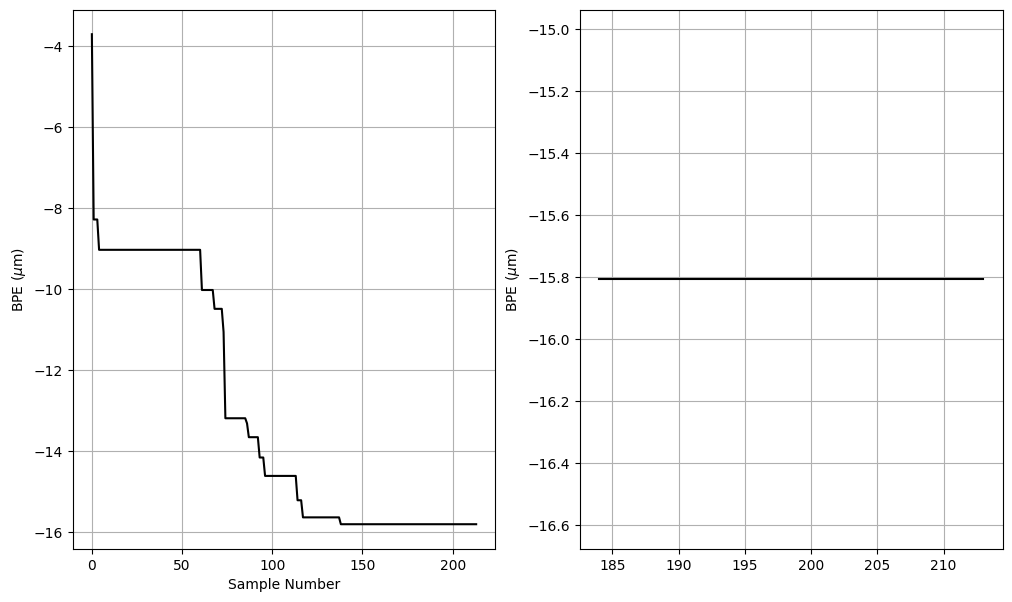

In [142]:
y1 = X.generator.data["f"]#/10
y1_mins = np.minimum.accumulate(y1)


idx = np.arange(len(y1_mins))
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 7))
ax0.plot(idx, y1_mins,'k')
ax0.grid()
ax0.set_xlabel("Sample Number")
ax0.set_ylabel("BPE ($\mu$m)")

ax1.plot(idx[-30:], y1_mins[-30:],'k')
ax1.grid()
ax1.set_ylabel("BPE ($\mu$m)");

In [143]:
min_idx = np.argmin(X.generator.data["f"])
min_val = X.generator.data["f"][min_idx]
X_min = [X.generator.data["x1"][min_idx],
         X.generator.data["x2"][min_idx],
          X.generator.data["x3"][min_idx],
         X.generator.data["x4"][min_idx],
         X.generator.data["x5"][min_idx],
         X.generator.data["x6"][min_idx],
          X.generator.data["x7"][min_idx],
          X.generator.data["x8"][min_idx]
         ]
inputs = np.array(X_min)
inputs = inputs[np.newaxis,:]
outs = get_snd_outputs_detailed(inputs)
print("Optimum Inputs: ", X_min)
print("BPE: ", outs[0][0].item())
print("Intensity:", outs[0][1].item())
print(outs[0][0].item()/outs[0][1].item(), min_val)

Optimum Inputs:  [0.5157133019832626, 0.47921137598930375, 0.44875594041703676, 0.5909072198862447, 0.55032410439675, 0.5859466873450527, 0.3520627618475895, 0.6089672244785391]
BPE:  0.8636255860328674
Intensity: 63317.4609375
1.3639611779211159e-05 -15.80770206451416


In [ ]:
len(X.data)

164

In [ ]:
X.evaluate_data(dummy)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.645086,0.814604,0.660841,0.903968,0.783687,0.614391,0.177168,0.25804,0.000005,0.754401,False


In [ ]:
dummy = {'x1':0.645086441371021,
         'x2':0.8146037558206418,
         'x3':0.6608410795425167,
         'x4':0.9039683133672296,
         'x5':0.7836868091280601,
         'x6':0.6143911125056001,
         'x7':0.17716786499340237,
         'x8':0.2580395390657129}


In [ ]:
len(X.data)

165

In [ ]:
sampler = qmc.Sobol(d=8)
xs = sampler.random(n=16)
xs.shape

(16, 8)

In [ ]:
X.data.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'f', 'xopt_runtime',
       'xopt_error'],
      dtype='object')

In [ ]:
sampler = qmc.Sobol(d=8)
xs = sampler.random(n=16)
init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.953314,0.665575,0.831064,0.209382,0.868921,0.326619,0.459929,0.013216,0.008759,0.355299,False
1,0.138491,0.476718,0.194109,0.506594,0.262753,0.548459,0.664081,0.518558,0.008704,0.329533,False
2,0.491794,0.910664,0.731189,0.261601,0.090888,0.806102,0.070182,0.807908,0.012985,0.336812,False
3,0.666481,0.223760,0.368633,0.964149,0.540867,0.068943,0.805843,0.286884,0.012985,0.341261,False
4,0.593139,0.784998,0.106493,0.816858,0.716175,0.401060,0.211647,0.970349,0.005541,0.328483,False
5,0.252682,0.096139,0.992960,0.395380,0.165605,0.723897,0.912394,0.499190,0.012837,0.338899,False
6,0.118128,0.545776,0.455760,0.650390,0.493694,0.982089,0.321853,0.210354,0.012978,0.359952,False
7,0.786223,0.358870,0.569782,0.071621,0.887953,0.142832,0.554080,0.697203,0.012975,0.328614,False
8,0.819692,0.967740,0.391978,0.450319,0.354117,0.003652,0.153274,0.923373,0.006108,0.333112,False
9,0.026109,0.155592,0.504534,0.778842,0.779621,0.871427,0.970705,0.420899,0.008678,0.332071,False


In [ ]:
len(X.data)

181

In [ ]:
get_snd_outputs_detailed(np.ones((1,8))*0.5)

tensor([[2.7091e-02, 6.1618e+04]])

In [ ]:
sampler = qmc.Sobol(d=8)
xs = sampler.random(n=n_init)
init_samples = pd.DataFrame({f'x{i+1}': xs[:,i] for i in range(xs.shape[1])})
X.evaluate_data(init_samples)

In [ ]:
len(X.vocs.variables)

8

In [ ]:
def sobol_evaluate(X: Xopt, n_init: int, seed=None):
  dim = len(X.vocs.variables)
  sampler = qmc.Sobol(d=dim, seed=None)
  xs = sampler.random(n=n_init)
  init_samples = pd.DataFrame({key: xs[:,i] for i, key in enumerate(X.vocs.variables.keys())})
  X.evaluate_data(init_samples)


def lhs_evaluate(X: Xopt, n_init: int, seed=None):
  dim = len(X.vocs.variables)
  sampler = qmc.LatinHypercube(d=dim, seed=None)
  xs = sampler.random(n=n_init)
  init_samples = pd.DataFrame({key: xs[:,i] for i, key in enumerate(X.vocs.variables.keys())})
  X.evaluate_data(init_samples)

In [ ]:
evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(
    vocs=vocs, turbo_controller="optimize"
)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [ ]:
lhs_evaluate(X, 4)
print(len(X.data))
print(X.data)

8
         x1        x2        x3        x4        x5        x6        x7  \
0  0.537928  0.582886  0.623680  0.833472  0.535630  0.150657  0.128636   
1  0.178109  0.831176  0.905536  0.667707  0.101968  0.273115  0.484433   
2  0.388306  0.228859  0.104494  0.465527  0.262808  0.531509  0.737903   
3  0.989049  0.401314  0.312389  0.243119  0.980209  0.839985  0.937847   
4  0.353724  0.276473  0.374984  0.563468  0.738026  0.435343  0.981809   
5  0.565863  0.958892  0.009776  0.223651  0.358077  0.842735  0.199809   
6  0.916743  0.748523  0.971323  0.387704  0.894873  0.226803  0.530080   
7  0.090002  0.118213  0.610148  0.772966  0.004624  0.648653  0.462126   

         x8             f  xopt_runtime  xopt_error  
0  0.768641  4.730350e-07      1.144312       False  
1  0.062214  4.421111e-07      0.670537       False  
2  0.653614  1.753457e-07      0.558305       False  
3  0.406060  4.718501e-07      0.989203       False  
4  0.398549  4.737492e-07      0.593072       False 